Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 54.17it/s]

<class 'networkx.classes.graph.Graph'>
62


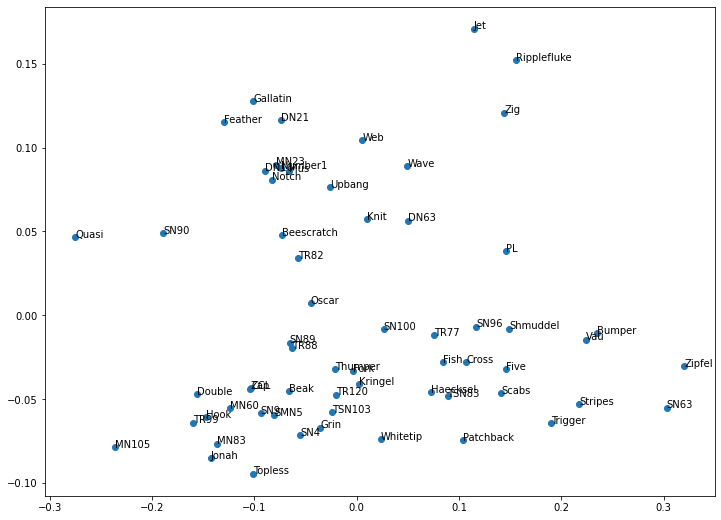

In [2]:
# 使用Node2Vec对space_data进行压缩
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 数据加载，构造图
G = nx.read_gml('dolphins.gml')
print(type(G))
#G = nx.read_gml('football.gml', relabel=True)
print(len(G))

# 初始化Node2Vec模型
#model = DeepWalk(G, walk_length=10, num_walks=5, workers=1)
model = Node2Vec(G, walk_length = 10, num_walks = 5, p = 0.25, q = 4, workers = 1)
# 模型训练
result = model.fit(window=4, iter=20)
# 得到节点的embedding
embeddings = result.wv
print(embeddings)

# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
    # 每个节点的embedding为100维
    X = []
    for item in word_list:
        X.append(embeddings[item])
    #print(X.shape)
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(list(word_list)):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))        
    plt.show()
    
plot_nodes(result.wv.vocab)


100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 7770.71it/s]

62
Word2Vec(vocab=62, size=100, alpha=0.03)


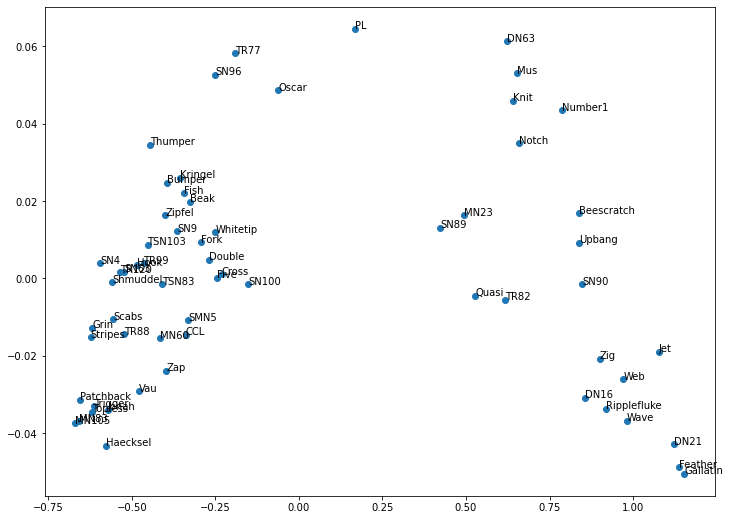

In [3]:
# 使用DeepWalk
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 数据加载，构造图
G = nx.read_gml('dolphins.gml')
#球队总数
print(len(G)) 
#都有哪些球队
#print(G.nodes()) 
#都有哪些比赛
#print(G.edges()) 

""" 
随机游走
input: 将节点和被遍历的路径的长度作为输入
output: 返回遍历节点的顺序:
"""
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node        
    return random_walk

#print(get_randomwalk('EastCarolina', 10))
# 从图获取所有节点的列表
all_nodes = list(G.nodes())
# 捕获数据集中所有节点的随机游走序列
random_walks = []
for n in tqdm(all_nodes):
	# 每个节点游走5次，每次最长距离为10
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        

# 输出随机游走序列，及序列个数
#print(random_walks)
#print(len(random_walks))

# 使用skip-gram，提取模型学习到的权重
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# 训练skip-gram (word2vec)模型
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # 负采样
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)
# 从random_walks中创建词汇表
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print(model)
# 输出和EastCarolina相似的球队


# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
	# 每个节点的embedding为100维
    X = model[word_list]
    #print(type(X))
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))        
    plt.show()
# 将所有的球队embedding进行绘制
plot_nodes(model.wv.vocab)

